## Import packages

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import masw_functions as mf
import pickle
import os
import subprocess
%matplotlib inline

## Read data

Read the file **dispersion_1000.pkl** with the list of dispersion analysis by azimuth of shot **1000**

In [2]:
filenames=["dispersion_1000.pkl","picking_1000.pkl"]
for filename in filenames:
    if os.path.isfile(filename):
        print(filename+" exists.")
    else: 
        url = 'https://filedn.com/lEzjnrJwSG47nSDwzIitUuf'
        folder='/Data/swi_python/'
        command = ['wget', url+folder+filename]
        subprocess.run(command)

with open(filenames[0], 'rb') as f:
    DispersionAzimuth = pickle.load(f)
with open(filenames[1], 'rb') as f:
    DispersionCurves = pickle.load(f)

dispersion_1000.pkl exists.
picking_1000.pkl exists.


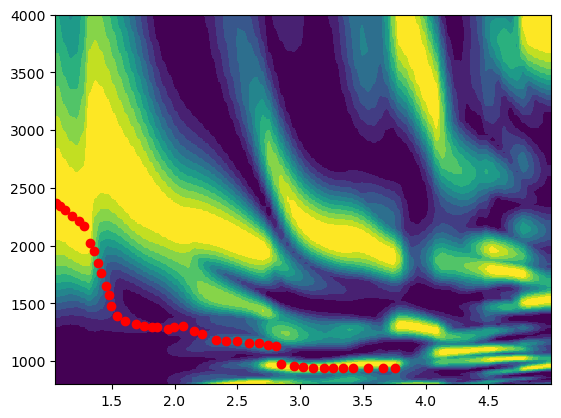

In [3]:
from IPython.display import clear_output, display
import time
fig, ax = plt.subplots()
cmap = plt.get_cmap('viridis', 12)
vmin, vmax = 800,4000
for bidx in range(len(DispersionAzimuth)):       
    [Pn, freq, Xobs]=DispersionAzimuth[bidx]
    pts=DispersionCurves[bidx]
    ax.clear()
    ax.imshow(Pn, aspect='auto', cmap=cmap, origin='lower', extent=[freq[0], freq[-1], vmin, vmax])
    ax.scatter(pts[:,0],pts[:,1],color='red')
    clear_output(wait=True)
    display(fig)
    time.sleep(1.0)
plt.close(fig)

In [4]:
bidx=2
Nh=10
rps=2.5
alpha=10
n_iter=10
dh=10.0
ModelResult=[]
error_bidx=[]
for bidx in range(len(DispersionCurves)):
    try:
        Xobs = DispersionCurves[bidx]
        (vsia,hia,zia)=mf.InitialModel(Xobs,Nh)
        rhoia=2*np.ones(np.size(vsia))
        hia=np.round(hia/dh)*dh
        (vsfa,vpfa,error)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsia,rhoia,hia,rps,n_iter,alpha,dh)
        ModelResult.append((vsfa, hia))
    except Exception as e:
        error_bidx.append(bidx)
        print(f"An error occurred: {e}")
    print(bidx)

  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/10 [00:00<?, ?it/s]

1


  0%|          | 0/10 [00:00<?, ?it/s]

2


  0%|          | 0/10 [00:00<?, ?it/s]

3


  0%|          | 0/10 [00:00<?, ?it/s]

4


  0%|          | 0/10 [00:00<?, ?it/s]

5


  0%|          | 0/10 [00:00<?, ?it/s]

6


  0%|          | 0/10 [00:00<?, ?it/s]

7


  0%|          | 0/10 [00:00<?, ?it/s]

8


  0%|          | 0/10 [00:00<?, ?it/s]

9


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

11


  0%|          | 0/10 [00:00<?, ?it/s]

12


  0%|          | 0/10 [00:00<?, ?it/s]

13


  0%|          | 0/10 [00:00<?, ?it/s]

/home/ivan/Documents/SW_Inversion_3D_Data/masw_functions.py:89: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  cR[i] = np.abs(fsolve(dispersion, x0=c0,  args=(vs,vp,rho,h,f[i]), xtol=1e-10))
/home/ivan/Documents/SW_Inversion_3D_Data/masw_functions.py:135: RuntimeWarning: invalid value encountered in sqrt
  v=np.sqrt(k**2-(w/vs[-1])**2)


An error occurred: SVD did not converge
14


  0%|          | 0/10 [00:00<?, ?it/s]

15


  0%|          | 0/10 [00:00<?, ?it/s]

16


  0%|          | 0/10 [00:00<?, ?it/s]

17


  0%|          | 0/10 [00:00<?, ?it/s]

18


  0%|          | 0/10 [00:00<?, ?it/s]

19


  0%|          | 0/10 [00:00<?, ?it/s]

20


  0%|          | 0/10 [00:00<?, ?it/s]

21


  0%|          | 0/10 [00:00<?, ?it/s]

22


In [5]:
for bidx in error_bidx:
    alpha=20
    Xobs = DispersionCurves[bidx]
    (vsia,hia,zia)=mf.InitialModel(Xobs,Nh)
    rhoia=2*np.ones(np.size(vsia))
    hia=np.round(hia/dh)*dh
    (vsfa,vpfa,error)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsia,rhoia,hia,rps,n_iter,alpha,dh)
    ModelResult.insert(bidx,(vsfa, hia))

    print(bidx)

  0%|          | 0/10 [00:00<?, ?it/s]

14


In [6]:
len(ModelResult)

23

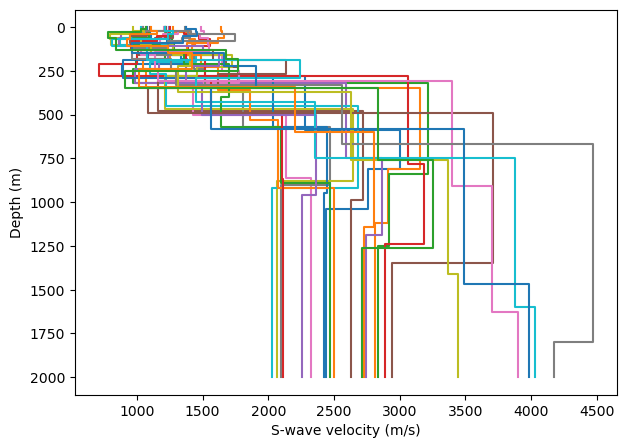

In [7]:
plt.rcParams['figure.figsize'] = [7, 5]
plt.figure()
for bidx in range(len(ModelResult)):
    (vsfa, hia)=ModelResult[bidx]
    zia=np.append(0,np.cumsum(hia))
    zia=np.append(zia,2000)
    plt.step(np.append(vsfa,vsfa[-1]),zia)
plt.xlabel('S-wave velocity (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()

In [8]:
from scipy.interpolate import interp1d
nz=201
zf=2000
vs2d = np.zeros((nz,len(ModelResult)))
znew=np.linspace(0,zf,nz)
for bidx in range(len(ModelResult)):
    (vsfa, hia)=ModelResult[bidx]
    zia=np.append(0,np.cumsum(hia))
    zia=np.append(zia,zf)
    f = interp1d(zia, np.append(vsfa,vsfa[-1]), kind='linear') 
    vs2d[:,bidx]=f(znew)

Text(0, 0.5, 'Depth (m)')

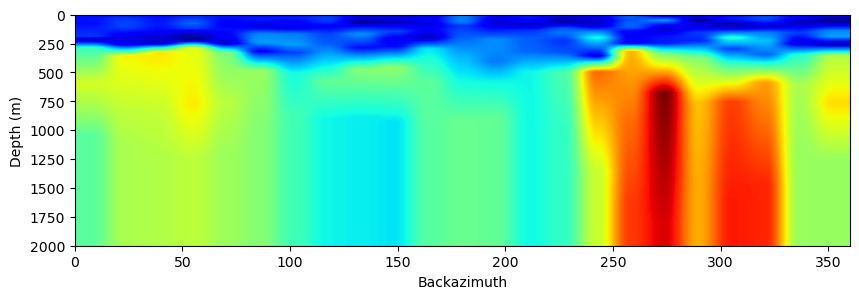

In [9]:
plt.rcParams['figure.figsize'] = [10, 3]
cmap = plt.get_cmap('jet', 12)
plt.imshow(vs2d, aspect='auto', cmap='jet', origin='upper', extent=[0, 360, 2000, 0])
plt.xlabel('Backazimuth')
plt.ylabel('Depth (m)')

In [11]:
# Save Dispersion Analysis info as .pkl
if 0:
      filedis="vs2d_1000.pkl"
      if os.path.isfile(filedis):
            print(filedis+" exists.")
      else: 
            with open(filedis, 'wb') as f:
                  pickle.dump(vs2d, f)